In [36]:
# Import required librareis
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

# Load the data
data = pd.read_csv('depression.csv')

########## Data Preproccesing ########################

# Extract the columns that suitable for model training
data = data[["Gender","Age","Education Level","Marital Status","Household Size","Household Income","Full Time Work","Work Type","Time In Current Job","Out Of Work","Trouble Sleeping History","Sleep Hours","Vigorous Recreation","Sedentary Time","Vigorous Work","Moderate Work","Cant Work","Lifetime Alcohol Consumption","Pregnant","Health Problem Heart","Health Problem Diabetes","Current Smoker","Depression"]]

# Replace "missing" with NaN in the entire dataframe
data = data.apply(lambda x: x.str.strip().replace('Missing', pd.NA) if x.dtype == "object" else x)

######### Encoding categorical values to numerical #############

encoder = LabelEncoder()
## encode the Gender column
data['Gender'] = encoder.fit_transform(data['Gender'])

## encode the Depression column
data["Depression"] = data["Depression"].replace({"Not Depressed": 0, "Depressed": 1})

data.head(2)

,Gender,Age,Education Level,Marital Status,Household Size,Household Income,Full Time Work,Work Type,Time In Current Job,Out Of Work,...,Sedentary Time,Vigorous Work,Moderate Work,Cant Work,Lifetime Alcohol Consumption,Pregnant,Health Problem Heart,Health Problem Diabetes,Current Smoker,Depression
0,0,44,Some College or AA Degree,Married,4,$75K+,<NA>,Private Wage Worker,324.0,<NA>,...,150.0,No,No,No,Yes,No,No,No,<NA>,0
1,1,70,College Graduate or Above,Married,2,$75K+,No,Private Wage Worker,96.0,<NA>,...,150.0,No,No,No,<NA>,<NA>,No,No,<NA>,0


In [37]:
data.shape                                                          

(36259, 23)

In [38]:
# view the null values in each column
data.isnull().sum()

Gender                              0
Age                                 0
Education Level                  2157
Marital Status                   1636
Household Size                      0
Household Income                 1813
Full Time Work                  30492
Work Type                       16284
Time In Current Job                 0
Out Of Work                     21461
Trouble Sleeping History            0
Sleep Hours                         0
Vigorous Recreation                 3
Sedentary Time                      0
Vigorous Work                       0
Moderate Work                       0
Cant Work                           0
Lifetime Alcohol Consumption    22323
Pregnant                        28366
Health Problem Heart                0
Health Problem Diabetes             0
Current Smoker                  20789
Depression                          0
dtype: int64

In [39]:
# Drop the columns that have more than 10000 null values
data = data.dropna(axis=1, thresh=len(data)-10000)

# Drop the rows that contain any null value
data = data.dropna(axis=0)

In [40]:
data.corr()["Depression"]

Gender                -0.077534
Age                   -0.010262
Household Size        -0.007909
Time In Current Job   -0.087375
Sleep Hours           -0.085884
Sedentary Time         0.033815
Depression             1.000000
Name: Depression, dtype: float64

In [41]:
data["Depression"].value_counts()

0    29578
1     2838
Name: Depression, dtype: int64

In [42]:

# Replace the "Some College or AA Degree" category with "College"
data["Education Level"] = data["Education Level"].replace("Some College or AA Degree", "College or Degree")

# view available categories in Education Level column 
data["Education Level"].value_counts()

College or Degree            9715
College Graduate or Above    7528
High School                  7517
9-11th Grade                 4541
Less Than 9th Grade          3115
Name: Education Level, dtype: int64

In [43]:
# view available categories in Marital Status column 
data["Marital Status"].value_counts()

Married          16781
Never Married     5765
Divorced          3619
Partner           2643
Widowed           2528
Separated         1080
Name: Marital Status, dtype: int64

In [44]:


# Define a custom function to categorize income
def categorize_income(income):
    if income in ["Below $5K", "Below $10K", "Below $15K", "Below $20K", "Below $25K", "Below $35K"]:
        return "Below 40k"
    else:
        return "Above 40k"

# Apply the custom function to the "Household Income" variable
data["Household Income"] = data["Household Income"].apply(categorize_income)

# view available categories in Household Income column 
data["Household Income"].value_counts()

Above 40k    17916
Below 40k    14500
Name: Household Income, dtype: int64

In [45]:
## encode the Trouble Sleeping column
data["Trouble Sleeping"] = data["Trouble Sleeping History"].replace({"Yes": 1, "No": 0})


In [46]:
## encode the Vigorous Recreation column and set to a new colum called Recreation
data["Recreation"] = data["Vigorous Recreation"].replace({"Yes": 1, "No": 0})


In [47]:
## encode the Vigorous Work column
data["Vigorous Work"] = data["Vigorous Work"].replace({"Yes": 1, "No": 0})

In [48]:
## encode the Moderate Work column
data["Moderate Work"] = data["Moderate Work"].replace({"Yes": 1, "No": 0})

In [49]:
## encode the Cant Work column and set to a new colum called Can Work
data["Can Work"] = data["Cant Work"].replace({"Yes": 0, "No": 1})

In [50]:
## encode the Health Problem Heart column and set to a new colum called Heart Problem
data["Heart Problem"] = data["Health Problem Heart"].replace({"Yes": 1, "No": 0})

## encode the Health Problem Diabetes column and set to a new colum called Diabetes
data["Diabetes"] = data["Health Problem Diabetes"].replace({"Yes": 1, "No": 0})

## specify the columns that need to droped because we assigned the content to new columns
columns_to_drop = ["Trouble Sleeping History", "Vigorous Recreation", "Cant Work","Health Problem Diabetes","Health Problem Heart"]

# Use the drop() method to drop the columns
data = data.drop(columns_to_drop, axis=1)

In [51]:
data.head()

,Gender,Age,Education Level,Marital Status,Household Size,Household Income,Time In Current Job,Sleep Hours,Sedentary Time,Vigorous Work,Moderate Work,Depression,Trouble Sleeping,Recreation,Can Work,Heart Problem,Diabetes
0,0,44,College or Degree,Married,4,Above 40k,324.0,9.0,150.0,0,0,0,0,0,1,0,0
1,1,70,College Graduate or Above,Married,2,Above 40k,96.0,7.0,150.0,0,0,0,0,0,1,0,0
2,1,73,High School,Married,2,Below 40k,0.0,7.0,90.0,0,1,0,1,0,1,0,0
5,1,21,High School,Never Married,6,Below 40k,3.0,8.0,180.0,0,0,0,0,1,1,0,0
6,0,85,9-11th Grade,Widowed,1,Below 40k,0.0,8.0,300.0,0,0,0,0,0,1,0,0


In [52]:
## create dummie collumns to convert categorical columns to numerical set of columns
data = pd.get_dummies(data, columns=["Education Level","Marital Status","Household Income"])

In [53]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32416 entries, 0 to 36258
Data columns (total 27 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Gender                                     32416 non-null  int32  
 1   Age                                        32416 non-null  int64  
 2   Household Size                             32416 non-null  int64  
 3   Time In Current Job                        32416 non-null  float64
 4   Sleep Hours                                32416 non-null  float64
 5   Sedentary Time                             32416 non-null  float64
 6   Vigorous Work                              32416 non-null  int64  
 7   Moderate Work                              32416 non-null  int64  
 8   Depression                                 32416 non-null  int64  
 9   Trouble Sleeping                           32416 non-null  int64  
 10  Recreation            

In [54]:
data.head()

,Gender,Age,Household Size,Time In Current Job,Sleep Hours,Sedentary Time,Vigorous Work,Moderate Work,Depression,Trouble Sleeping,...,Education Level_High School,Education Level_Less Than 9th Grade,Marital Status_Divorced,Marital Status_Married,Marital Status_Never Married,Marital Status_Partner,Marital Status_Separated,Marital Status_Widowed,Household Income_Above 40k,Household Income_Below 40k
0,0,44,4,324.0,9.0,150.0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
1,1,70,2,96.0,7.0,150.0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
2,1,73,2,0.0,7.0,90.0,0,1,0,1,...,1,0,0,1,0,0,0,0,0,1
5,1,21,6,3.0,8.0,180.0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,1
6,0,85,1,0.0,8.0,300.0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1


In [55]:
data.columns

Index(['Gender', 'Age', 'Household Size', 'Time In Current Job', 'Sleep Hours',
       'Sedentary Time', 'Vigorous Work', 'Moderate Work', 'Depression',
       'Trouble Sleeping', 'Recreation', 'Can Work', 'Heart Problem',
       'Diabetes', 'Education Level_9-11th Grade',
       'Education Level_College Graduate or Above',
       'Education Level_College or Degree', 'Education Level_High School',
       'Education Level_Less Than 9th Grade', 'Marital Status_Divorced',
       'Marital Status_Married', 'Marital Status_Never Married',
       'Marital Status_Partner', 'Marital Status_Separated',
       'Marital Status_Widowed', 'Household Income_Above 40k',
       'Household Income_Below 40k'],
      dtype='object')

In [56]:
# Divide the data into independent and target variables
# Independent variables
X = data.drop("Depression", axis=1) 

# Target variable
y = data["Depression"] 

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6484 entries, 22722 to 25735
Data columns (total 26 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Gender                                     6484 non-null   int32  
 1   Age                                        6484 non-null   int64  
 2   Household Size                             6484 non-null   int64  
 3   Time In Current Job                        6484 non-null   float64
 4   Sleep Hours                                6484 non-null   float64
 5   Sedentary Time                             6484 non-null   float64
 6   Vigorous Work                              6484 non-null   int64  
 7   Moderate Work                              6484 non-null   int64  
 8   Trouble Sleeping                           6484 non-null   int64  
 9   Recreation                                 6484 non-null   int64  
 10  Can Work           

In [57]:

# Train a Desicion Tree model
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)



DecisionTreeClassifier()

In [58]:
## evaluate the model for smaple data set
sample_data = pd.DataFrame([[1, 1, 1, 2, 3, 2, 0, 1, 0, 0, 1, 1, 0,1, 1, 1, 1, 1,1, 0, 1, 0, 0, 1, 1, 0]],
                           columns=X.columns)
predicted_depression = dt.predict(sample_data)

print(predicted_depression)

[0]


In [59]:
# Evaluate the performance of the model on the testing set
score = dt.score(X_test, y_test)
print("Accuracy on testing set: {:.2f}%".format(score * 100))

Accuracy on testing set: 85.21%


In [60]:
from sklearn.metrics import confusion_matrix

y_pred = dt.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[5389  536]
 [ 423  136]]


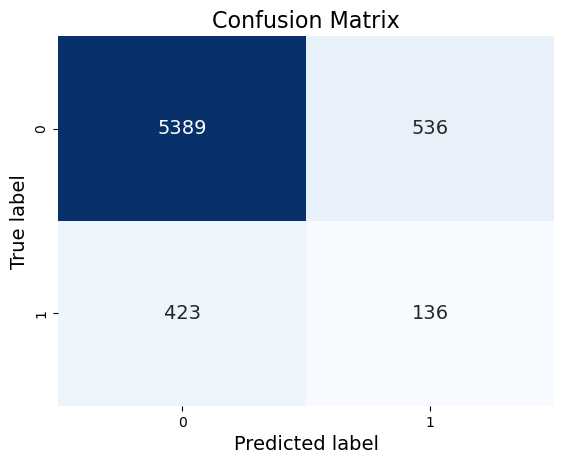

In [61]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
# Use the SVM model to predict the labels for the testing set
y_pred = dt.predict(X_test)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix as a heatmap using Seaborn
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", cbar=False, annot_kws={"fontsize":14})
plt.xlabel("Predicted label", fontsize=14)
plt.ylabel("True label", fontsize=14)
plt.title("Confusion Matrix", fontsize=16)
plt.show()


In [62]:
from sklearn.metrics import classification_report

# Make predictions on the testing set
y_pred = dt.predict(X_test)

# Print the classification report
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.93      0.91      0.92      5925
           1       0.20      0.24      0.22       559

    accuracy                           0.85      6484
   macro avg       0.56      0.58      0.57      6484
weighted avg       0.86      0.85      0.86      6484



In [63]:
from sklearn.metrics import precision_score, recall_score, f1_score

# y_true and y_pred are the true and predicted labels, respectively
precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=1)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=1)
precision

0.8647296053443347

In [64]:
recall

0.8520974706971005

In [65]:
f1

0.8581738697555039